In [14]:
%store -r df_10ksp_filtered3
%store -r df_10ksp_filtered4
%store -r df_10ksp_filtered5

In [3]:
import pandas as pd
import numpy as np
df_final=pd.read_csv('df_final.csv')

/var/folders/nr/053gf3x97yg912g1cs827wrw0000gn/T/ipykernel_11286/3451920016.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final=pd.read_csv('df_final.csv')


In [4]:
#add auxiliary data
#gdp growth
growth_url = 'https://github.com/ethancn01/10ksentimentalanalysis/blob/main/GDP_growth.xls?raw=true'
growth = pd.read_excel(growth_url)
gdp_growth_usa = growth.loc[growth['Country Code'] == 'USA', '1999':'2022'].T
gdp_growth_usa.columns = ['GDP Growth']
gdp_growth_usa.index.name = 'Year'
gdp_growth_usa.reset_index(inplace=True)
gdp_growth_usa['Year'] = gdp_growth_usa['Year'].astype(int)

In [34]:
import pandas as pd

# Data from 1999 to 2022
inflation_data = {
    'Year': [1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    'Inflation Rate (%)': [2.19, 3.38, 2.83, 1.59, 2.27, 2.68, 3.39, 3.23, 2.85, 3.84, -0.36, 1.64, 3.16, 2.07, 1.46, 1.62, 0.12, 1.26, 2.13, 2.44, 1.81, 1.23, 4.70, 8.00]
}

# Creating the DataFrame
inflation = pd.DataFrame(inflation_data)

# Display the first few rows of the DataFrame
print(inflation.head())


   Year  Inflation Rate (%)
0  1999                2.19
1  2000                3.38
2  2001                2.83
3  2002                1.59
4  2003                2.27


In [5]:
#clean df_final into a version with complete and samples
df_final2 = df_final[
    ~((df_final['Item 7 Content'] == 'Section not found.') & 
      (df_final['Item 7A Content'] == 'Section not found.'))
].reset_index()
df_final2['Item 7 Word Count'] = df_final2['Item 7 Content'].apply(lambda x: len(x.split()))
df_final2['Item 7A Word Count'] = df_final2['Item 7A Content'].apply(lambda x: len(x.split()))
df_final2['Total Word Count'] = df_final2['Item 7 Word Count'] + df_final2['Item 7A Word Count']
import re
for col in ['Item 7 Content', 'Item 7A Content']:
    df_final2[col] = df_final2[col].apply(lambda x: re.sub(r'(?i)Item 8.*', '', x))


In [6]:
for col in ['Item 7 Content']:
    df_final2[col] = df_final2[col].apply(lambda x: re.sub(r'(?i)Item 7A.*', '', x))
df_final2=df_final2[df_final2['Total Word Count']>=500]

In [7]:
df_final2.dropna(subset=['CONFORMED PERIOD OF REPORT'], inplace=True)
df_final2['Report Year'] = df_final2['CONFORMED PERIOD OF REPORT'].astype(str).str[:4]
df_final2['Report Year'] = pd.to_numeric(df_final2['Report Year'], errors='coerce', downcast='integer')

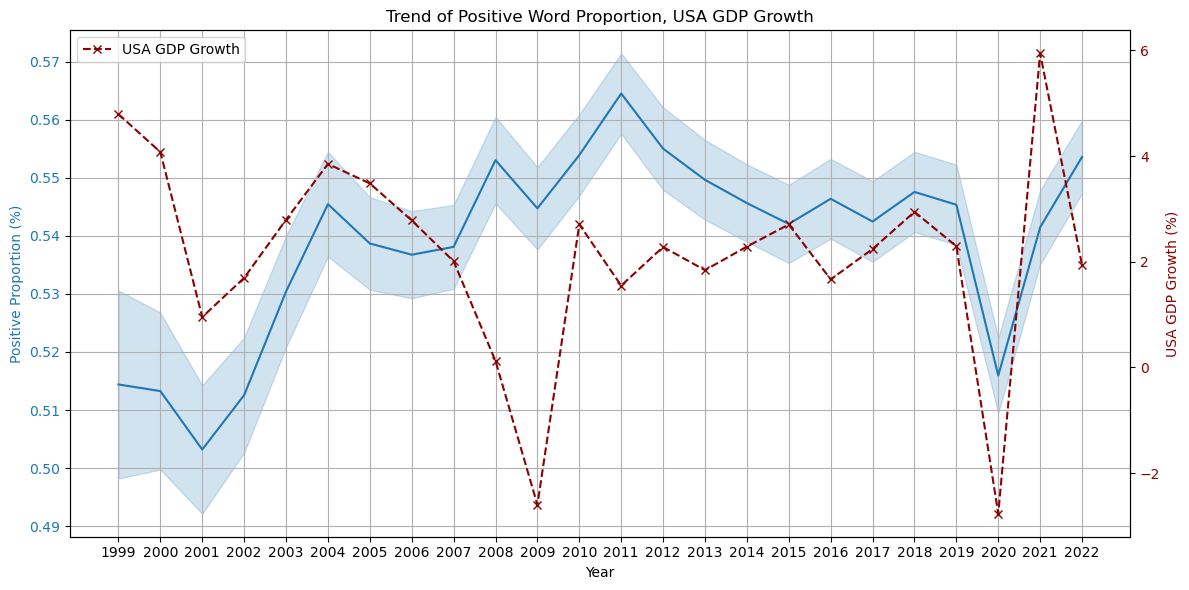

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Calculate the positive proportion and multiply by 100 for percentage
df_final2['Positive Proportion (%)'] = (df_final2['Positive'] / df_final2['Total Word Count']) * 100

# Group by 'Report Year' and calculate the mean, standard deviation, and count of the positive proportion
stats_df = df_final2.groupby('Report Year')['Positive Proportion (%)'].agg(['mean', 'std', 'count']).reset_index()

# Calculate the Standard Error of the Mean (SEM)
stats_df['SEM'] = stats_df['std'] / np.sqrt(stats_df['count'])

# Calculate the 95% Confidence Interval
# Z-score for 95% confidence is approximately 1.645
z_score = 1.6
stats_df['CI Lower'] = stats_df['mean'] - (z_score * stats_df['SEM'])
stats_df['CI Upper'] = stats_df['mean'] + (z_score * stats_df['SEM'])

# Ensure 'Year' in gdp_growth_usa is integer for proper alignment
gdp_growth_usa['Year'] = gdp_growth_usa['Year'].astype(int)

# Merge the datasets on the 'Year' column
merged_data = stats_df.merge(gdp_growth_usa, left_on='Report Year', right_on='Year')
# Merge inflation data with existing merged data
merged_data = merged_data.merge(inflation, on='Year')

# Adjust scale of inflation data to make it comparable
inflation_scaled = merged_data['Inflation Rate (%)'] * 10  # Scale inflation data for better visualization

# Plot with a shared x-axis and two different y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the Positive Proportion (%) with its Confidence Interval
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Positive Proportion (%)', color=color)
ax1.plot(merged_data['Report Year'], merged_data['mean'], color=color, label='Mean Positive Proportion')
ax1.fill_between(merged_data['Report Year'], merged_data['CI Lower'], merged_data['CI Upper'], color=color, alpha=0.2, label='89% Confidence Interval')
ax1.tick_params(axis='y', labelcolor=color)

# Plotting the USA GDP Growth on the second y-axis
ax2 = ax1.twinx()
color = '#8B0000'
ax2.set_ylabel('USA GDP Growth (%)', color=color)
ax2.plot(merged_data['Year'], merged_data['GDP Growth'], color=color, linestyle='--', marker='x', label='USA GDP Growth')
ax2.tick_params(axis='y', labelcolor=color)



# Adding titles and layout adjustments
plt.title('Trend of Positive Word Proportion, USA GDP Growth')
ax1.grid(True)
fig.tight_layout()
plt.xticks(merged_data['Report Year'])
plt.legend(loc='upper left')


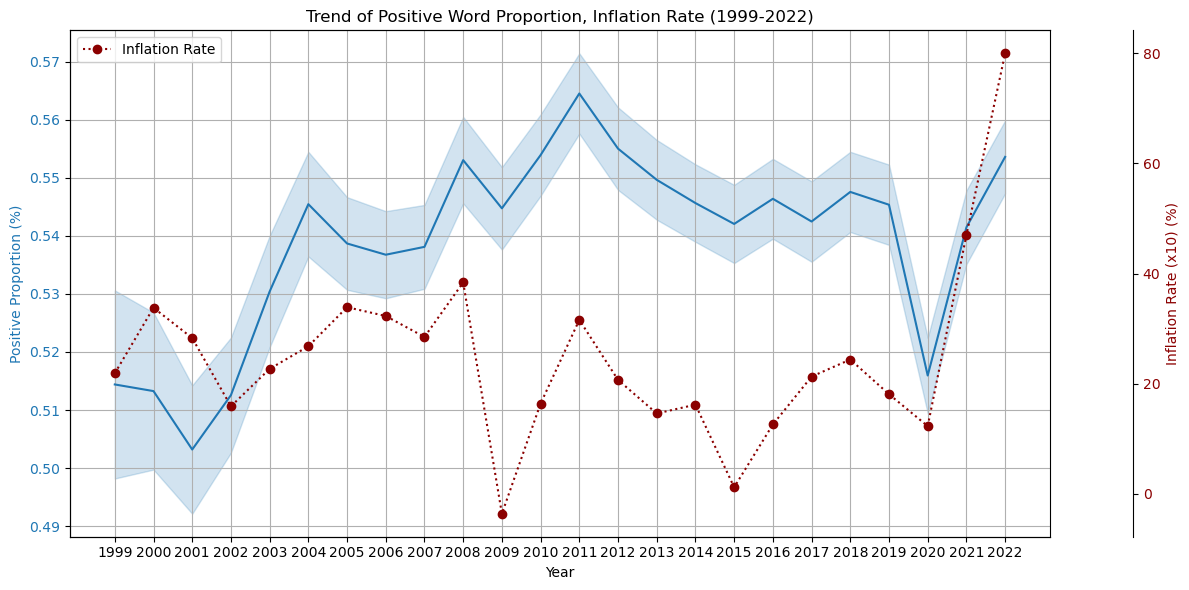

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assuming you have df_final2, gdp_growth_usa, and inflation datasets available

# Your existing code to calculate positive proportion and merge datasets
# ...

# Plot with a shared x-axis and two different y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the Positive Proportion (%) with its Confidence Interval
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Positive Proportion (%)', color=color)
ax1.plot(merged_data['Report Year'], merged_data['mean'], color=color, label='Mean Positive Proportion')
ax1.fill_between(merged_data['Report Year'], merged_data['CI Lower'], merged_data['CI Upper'], color=color, alpha=0.2, label='89% Confidence Interval')
ax1.tick_params(axis='y', labelcolor=color)

# Plotting the Inflation Rate on the second y-axis
ax2 = ax1.twinx()
color = '#8B0000'
ax2.set_ylabel('Inflation Rate (x10) (%)', color=color)
ax2.plot(merged_data['Year'], inflation_scaled, color=color, linestyle=':', marker='o', label='Inflation Rate')
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['right'].set_position(('outward', 60))  # Adjust position of the second y-axis



# Adding titles and layout adjustments
plt.title('Trend of Positive Word Proportion, Inflation Rate (1999-2022)')
ax1.grid(True)
fig.tight_layout()
plt.legend(loc='upper left')
plt.xticks(merged_data['Report Year'])
plt.show()


In [43]:
merged_data

,Report Year,mean,std,count,SEM,CI Lower,CI Upper,Year,GDP Growth,Inflation Rate (%)
0,1999.0,0.514410,0.284998,793,0.010121,0.498217,0.530603,1999,4.794499,2.19
1,2000.0,0.513268,0.291432,1190,0.008448,0.499751,0.526785,2000,4.077159,3.38
2,2001.0,0.503208,0.262907,1449,0.006907,0.492158,0.514259,2001,0.954339,2.83
3,2002.0,0.512568,0.251010,1643,0.006193,0.502660,0.522476,2002,1.695943,1.59
4,2003.0,0.530406,0.260408,1884,0.005999,0.520807,0.540005,2003,2.796209,2.27
5,2004.0,0.545448,0.257459,2092,0.005629,0.536442,0.554455,2004,3.852553,2.68
6,2005.0,0.538683,0.245885,2434,0.004984,0.530709,0.546657,2005,3.483220,3.39
7,2006.0,0.536746,0.233859,2489,0.004687,0.529246,0.544246,2006,2.782811,3.23
8,2007.0,0.538101,0.226349,2518,0.004511,0.530883,0.545318,2007,2.010508,2.85
9,2008.0,0.553030,0.242999,2730,0.004651,0.545588,0.560471,2008,0.122188,3.84


In [10]:
import pandas as pd
raw_url_dict = 'https://raw.githubusercontent.com/ethancn01/10ksentimentalanalysis/main/Loughran-McDonald_MasterDictionary_1993-2021.csv'
dict = pd.read_csv(raw_url_dict)
#quick view of the dict
columns_to_update = ['Negative', 'Positive', 'Uncertainty', 'Litigious', 'Strong_Modal', 'Weak_Modal', 'Constraining']

for column in columns_to_update:
    dict[column] = dict[column].apply(lambda x: 1 if x != 0 else 0)
dict

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Syllables,Source
0,AARDVARK,1,354,1.550080e-08,1.422600e-08,3.815486e-06,99,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.313627e-10,8.653817e-12,9.241714e-09,1,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.940882e-10,1.169679e-10,5.290465e-08,7,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.269840e-09,6.654735e-10,1.595100e-07,28,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,8570,3.752595e-07,3.809464e-07,3.529356e-05,1108,0,0,0,0,0,0,0,3,12of12inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86526,ZYGOTE,86529,50,2.189379e-09,8.729336e-10,1.886011e-07,35,0,0,0,0,0,0,0,2,12of12inf
86527,ZYGOTES,86530,1,4.378757e-11,1.809516e-11,1.932446e-08,1,0,0,0,0,0,0,0,2,12of12inf
86528,ZYGOTIC,86531,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf
86529,ZYMURGIES,86532,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf


In [62]:
from wordcloud import WordCloud
from collections import Counter

# Function to extract words from '7 content' and '7a content' columns
def extract_words_from_content(df):
    words = []
    for content in df['Item 7 Content']:
        words.extend(content.split())
    for content in df['Item 7A Content']:
        words.extend(content.split())
    return words

# Extract words from '7 content' and '7a content' columns
words = extract_words_from_content(df_final2)

# Create a Counter object to count word occurrences
word_counter = Counter(words)

# Function to filter words based on positive/negative sentiment
def filter_words_by_sentiment(word_list, sentiment):
    filtered_words = [word.lower() for word in word_list if word.lower() in dict[dict[sentiment] == 1]['Word'].values]
    return ' '.join(filtered_words)

# Generate word cloud for negative sentiment
negative_words = filter_words_by_sentiment(words, 'Negative')
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

# Generate word cloud for positive sentiment
positive_words = filter_words_by_sentiment(words, 'Positive')
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_words)

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')

plt.tight_layout()
plt.show()


In [15]:
import dask.dataframe as dd
import pandas as pd

# Convert DataFrame to Dask DataFrame
ddf_10ksp_filtered3 = dd.from_pandas(df_10ksp_filtered3, npartitions=4)

# Function to update sentiment dictionary based on words in df_column
def update_sentiment_dict(sentiment_dict, df_column):
    new_dict = sentiment_dict.copy()
    for content in df_column:
        words = content.split()
        for word in words:
            word = word.lower()
            if word in new_dict['Word'].values:
                new_dict.loc[new_dict['Word'] == word, 'Word Count'] += 1
    return new_dict

# Filter sentiment dictionary to rows where either 'Negative' or 'Positive' column is marked as 1
filtered_dict = dict[(dict['Negative'] == 1) | (dict['Positive'] == 1)]

# Update sentiment dictionary based on words in 'Item 7 Content'
updated_dict_item7 = update_sentiment_dict(filtered_dict, df_10ksp_filtered3['Item 7 Content'])

# Update sentiment dictionary based on words in 'Item 7A Content'
updated_dict_item7A = update_sentiment_dict(filtered_dict, df_10ksp_filtered3['Item 7A Content'])

# Count the total occurrences of positive and negative words
positive_word_count = updated_dict_item7[updated_dict_item7['Positive'] == 1]['Word Count'].sum().compute()
negative_word_count = updated_dict_item7[updated_dict_item7['Negative'] == 1]['Word Count'].sum().compute()

# Print the counts
print("Total occurrences of positive words:", positive_word_count)
print("Total occurrences of negative words:", negative_word_count)


AttributeError: 'numpy.int64' object has no attribute 'compute'

2024-03-01 23:14:29,925 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 15 memory: 168 MB fds: 283>>
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.11/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Applications/anaconda3/lib/python3.11/site-packages/distributed/system_monitor.py", line 160, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/anaconda3/lib/python3.11/site-packages/psutil/__init__.py", line 2117, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory
2024-03-02 13:52:07,426 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 8 memory: 62 MB fds: 285>>
Traceback (most recent call last):
  File "/Applic